In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/20210219/twitter.tar
/kaggle/input/20210219/github.tar
/kaggle/input/20210219/.dataset-metadata.json.un
/kaggle/input/20210219/bbc.tar


In [13]:
import pickle

from pprint import pprint
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [14]:
import tarfile

#simple function to extract the train data
#tar_file : the path to the .tar file
#path : the path where it will be extracted
def extract(tar_file, path):
    opened_tar = tarfile.open(tar_file)
     
    if tarfile.is_tarfile(tar_file):
        opened_tar.extractall(path)
    else:
        print("The tar file you entered is not a tar file")

In [15]:
extract('/kaggle/input/20210219/github.tar', '/kaggle/working/datasets')

In [16]:
DATA_PATH = "datasets/tfidf/"
df = pd.read_csv('datasets/contents.csv', dtype={'label': 'category'})

with open(DATA_PATH+'features_train.pickle', 'rb') as data:
    features_train = pickle.load(data)

with open(DATA_PATH+'labels_train.pickle', 'rb') as data:
    labels_train = pickle.load(data)

with open(DATA_PATH+'features_test.pickle', 'rb') as data:
    features_test = pickle.load(data)

with open(DATA_PATH+'labels_test.pickle', 'rb') as data:
    labels_test = pickle.load(data)

In [19]:
print(len(features_train), len(features_test))

127500 22500


# Default parameters

In [17]:
base_model = RandomForestClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.7258666666666667

In [18]:
pprint(base_model.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}


# Random Search

In [23]:
# sur un sous-ensemble de données
features_train_s = features_train[:20_000]
labels_train_s = labels_train[:20_000]

In [24]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 19)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(20, 100, num = 9)]
max_depth.append(None)
min_samples_split = [2, 4, 6, 8, 10, 12, 14]
min_samples_leaf = [1, 2, 4, 8]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid, compact=True)

{'bootstrap': [True, False],
 'max_depth': [20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 8],
 'min_samples_split': [2, 4, 6, 8, 10, 12, 14],
 'n_estimators': [200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200,
                  1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]}


In [25]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=100,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8,
                                   n_jobs=-1)

# Fit the random search model
random_search.fit(features_train_s, labels_train_s)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 102.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 167.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=8),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 30, 40, 50, 60, 70,
                                                      80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14],
                                        'n_estimators': [200, 300, 400, 500,
                                                         600, 700, 800, 900,
                                                         1000, 1100, 1200, 1300,
                                                         1400, 1500, 1600, 1700,
                                                  

In [26]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': True}

The mean accuracy of a model with these hyperparameters is:
0.7203501811108065


In [27]:
best_rfc = random_search.best_estimator_
best_rfc

RandomForestClassifier(max_depth=80, max_features='sqrt', min_samples_split=10,
                       n_estimators=500, random_state=8)

# Fit best model

In [ ]:
best_rfc.fit(features_train, labels_train)

# Performance analysis

In [29]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train)))

The training accuracy is: 
0.9188235294117647


In [30]:
rfc_pred = best_rfc.predict(features_test)

In [31]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred))

The test accuracy is: 
0.7310222222222222


In [32]:
# Classification report
print("Classification report")
print(classification_report(labels_test,rfc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.73      0.78      0.76     10024
           1       0.73      0.81      0.77     10366
           2       0.69      0.10      0.18      2110

    accuracy                           0.73     22500
   macro avg       0.72      0.57      0.57     22500
weighted avg       0.73      0.73      0.71     22500



In [33]:
def confusion(df, preds, y):
    aux_df = pd.concat([df.label, df.label.cat.codes], axis=1).rename(columns={0:'label_code'}).drop_duplicates().sort_values('label')
    conf_matrix = confusion_matrix(y, preds)
    plt.figure(figsize=(12.8,6))
    sns.heatmap(conf_matrix, 
                annot=True,
                xticklabels=aux_df['label'].values, 
                yticklabels=aux_df['label'].values,
                cmap="Blues")
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.title('Confusion matrix')
    plt.show()

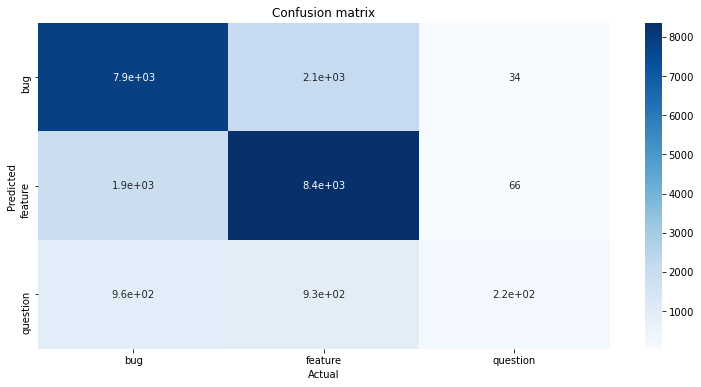

In [34]:
confusion(df, rfc_pred, labels_test)